## SAM + Stable Diffusion Inpainting


we will make an ambitious attempt to build a project that customizes an outfit based on any given prompt.

Here’s an overview of the steps in building this project:

1. Installing the required Python packages and related repositories
2. Importing the Python packages and methods
3. Setting up the Stable Diffusion Model pipeline
4. Getting the segmentation masks from SAM
5. Setting up transformation prompts
6. Displaying the customized outfits

## Let’s Build an Outfit Customizer: Combining Segmentation and Diffusion Generative Models

https://pub.aimind.so/lets-build-an-outfit-customizer-combining-segmentation-and-diffusion-generative-models-6c3c05734c58

### **Installing the Required Python Packages and Related Repositories**

In [ ]:
!pip install segment_anything
!pip install -q diffusers transformers accelerate scipy
!pip install -q regex tqdm
!pip install --no-dependencies xformers
!pip install -q pycocotools matplotlib onnxruntime onnx
!pip install segment_anything
!pip install -q diffusers transformers accelerate scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.5 MB/s eta 0:00:00


In [ ]:
# Install the SAM package

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!pip install xformers==0.0.22.post4 --index-url https://download.pytorch.org/whl/cu118

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7t5e9vgk
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7t5e9vgk
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2023-12-14 11:34:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.25, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  96.1MB/s    in 20s     

2023-12-14 11:34:34 (125 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]

Looki

### Note: after installation is complete (it make take a few minutes), you'll need to restart the runtime.

### **Importing the Python Packages and Methods**

In [ ]:
import torch
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import cv2
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import copy
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

### **Setting Up the Stable Diffusion Pipeline**

In [ ]:
# Retrieve the Stable Diffusion model to use
# Example: "Stable Diffusion ver. 2"
model_dir = "stabilityai/stable-diffusion-2-inpainting"

# Retrieve the appropriate scheduler
scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

# Setup the inpainting pipelin
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                      scheduler=scheduler,
                                                      revision="fp16",
                                                      torch_dtype=torch.float16)

# Cast the pipeline to CUDA
pipe = pipe.to("cuda")

# Enable memory efficient attention from xFormers for optimization
pipe.enable_xformers_memory_efficient_attention()

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
unet/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


### **Getting the Segmentation Masks from SAM**

In [ ]:
# Download a text image

!wget https://static-ph.zacdn.com/p/identity-7999-7249341-1.jpg

--2023-12-14 11:45:40--  https://static-ph.zacdn.com/p/identity-7999-7249341-1.jpg
Resolving static-ph.zacdn.com (static-ph.zacdn.com)... 18.154.206.118, 18.154.206.117, 18.154.206.127, ...
Connecting to static-ph.zacdn.com (static-ph.zacdn.com)|18.154.206.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372988 (364K) [image/jpeg]
Saving to: ‘identity-7999-7249341-1.jpg’

identity-7999-72493 100%[===================>] 364.25K   575KB/s    in 0.6s    

2023-12-14 11:45:42 (575 KB/s) - ‘identity-7999-7249341-1.jpg’ saved [372988/372988]



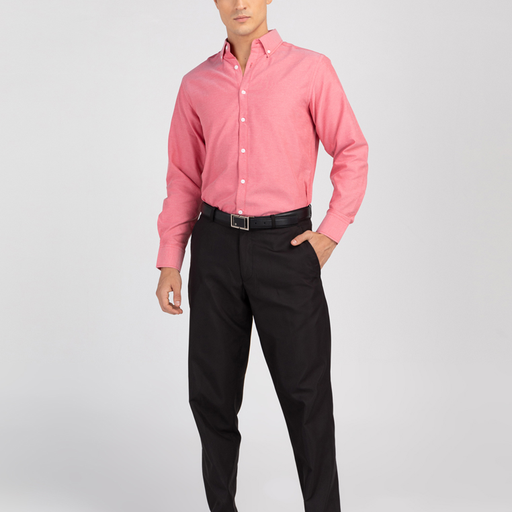

In [ ]:
# SAM model expects image of size 512-by-512
target_width, target_height = 512, 512


# Input the file location and file name
# Example: "model_img.png"
source_image = Image.open("identity-7999-7249341-1.jpg")

# Crop the image to a square
width, height = source_image.size
if width > height:
    left = (width - height) // 2
    right = width - left
    top = 0
    bottom = height
    source_image = source_image.crop((left, top, right, bottom))
else:
    top = (height - width) // 2
    bottom = height - top
    left = 0
    right = width
    source_image = source_image.crop((left, top, right, bottom))

# Resize the image to target width and height
source_image = source_image.resize((target_width, target_height), Image.Resampling.LANCZOS)

# Prepare image for segmentation
segmentation_image = np.asarray(source_image)

# Display image on notebook
display(source_image)

Let’s now setup the automatic mask generator from SAM.

In [ ]:
# Use the downloaded model checkpoint and specify the model type
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Register the device you want to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

# Cast the model to the device
sam.to(device)

# Setup the automatic mask generator
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=12,
    pred_iou_thresh=0.99,
    stability_score_thresh=0.93,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100
)

We can now proceed in retrieving segmentation masks. Enter a new cell and type in the following:

In [ ]:
masks = mask_generator.generate(segmentation_image)

Next, let’s build a utility function that automatically annotates the segmented areas in our source image using the retrieved segmentation masks. Use a new cell to define this function as shown below.

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return None

    # Sort masks by area in ascending order
    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]["area"]), reverse=True)
    ax = plt.gca()

    # Disable autoscale to keep the image size consistent
    ax.set_autoscale_on(False)

    # Iterate through each mask and display it on top of the original image
    for original_idx, ann in sorted_anns:
        m = ann["segmentation"]
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Generate a random color for the mask
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]

        # Blend the mask with the image using 0.35 as the alpha value for transparency
        ax.imshow(np.dstack((img, m*0.35)))

        # Find contours of the mask to compute the centroid
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)

            # Compute the centroid of the mask if the moment is non-zero
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])

                # Display the original index number (1-based) at the centroid of the mask
                # The text is white, bold, and has a font size of 16
                ax.text(cx, cy, str(original_idx), color="white", fontsize=16, ha="center", va="center", fontweight="bold")


Let’s display the segmented areas annotated using the segmentation masks that will help us decide which specific area in the source image we are going to apply inpainting. Since this is an outfit customizer, we select only the areas that reflect to any piece of clothing. Enter a new cell and type in the following:

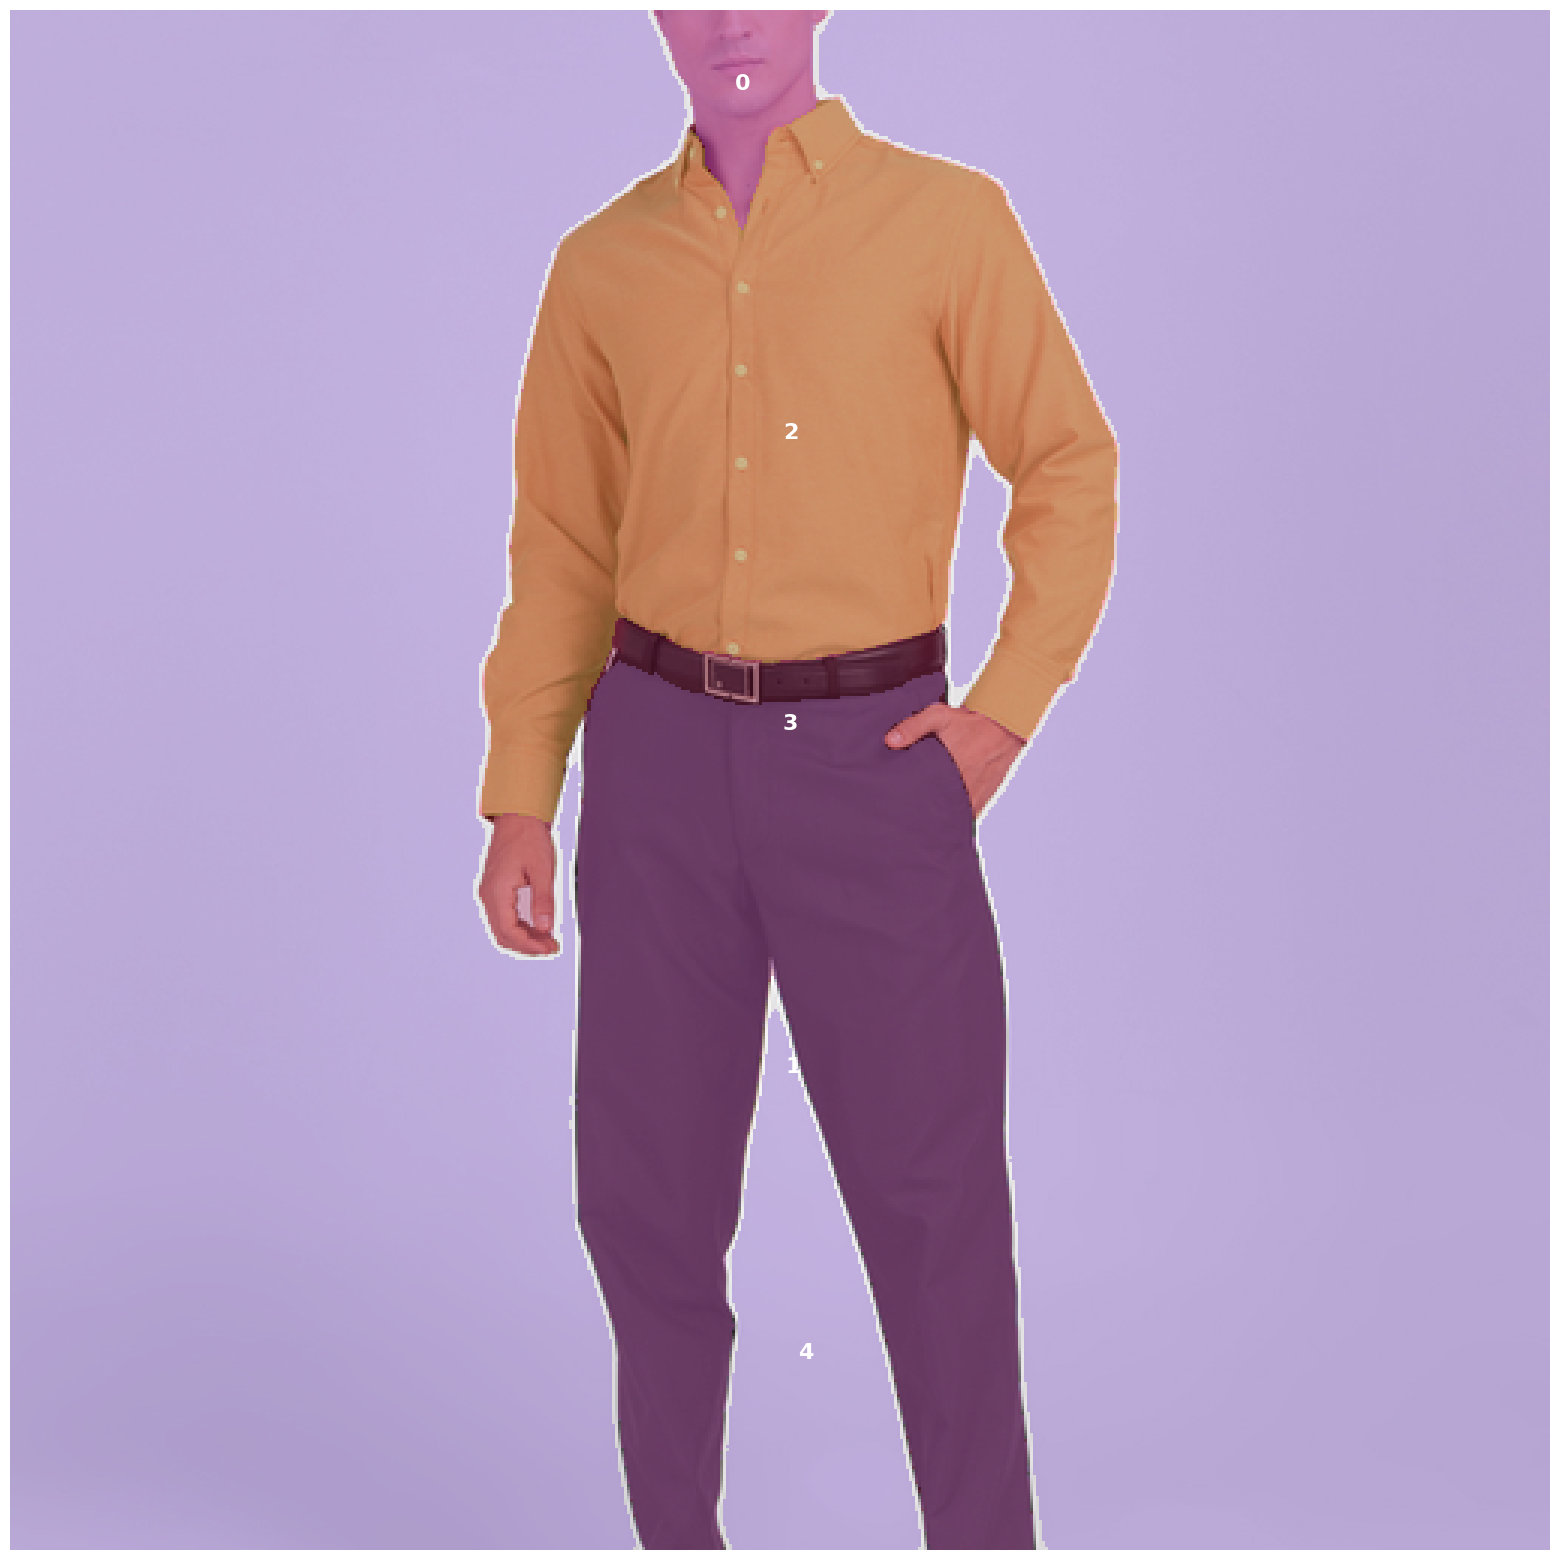

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(source_image)
show_anns(masks)
plt.axis("off")
plt.savefig("sample_img_masked.jpg")
plt.show()

Let’s say we want to customize the shirt that the model in our source image is wearing, so we choose mask with label 2. In a new cell, type in the following:

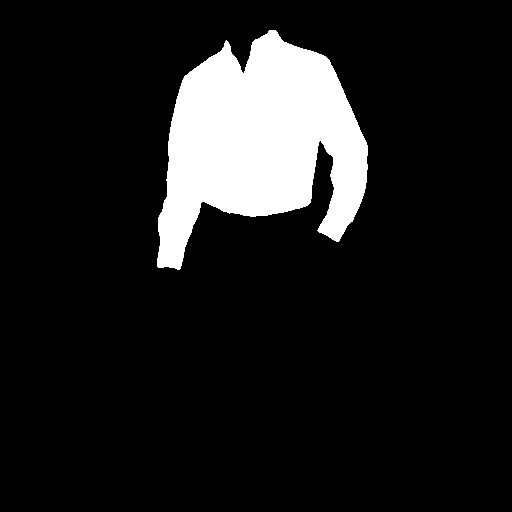

In [ ]:
# Decide which mask you want to do inpainting with
# Example: "2" to establish the shirt as reference
mask_index = 2

# Isolate the mask of the chosen reference
segmentation_mask = masks[mask_index]["segmentation"]

# Image processing to emphasize the mask
stable_diffusion_mask = Image.fromarray(segmentation_mask)

# Display image on notebook
display(stable_diffusion_mask)

### **Setting Up the Transformation Prompts**

In [ ]:
# Set the number of images associated to each prompt
num_images_per_prompt = 5

# Setup the transfomration prompts
inpainting_prompts = ["A shirt with duck patterns", "A shirt with beaver patterns", "A formal, green-colored, office-appropriate shirt", "A shirt with design inspired from the 80s", "A shirt with a floral pattern"]

# Generate a random seed
generator = torch.Generator(device="cuda").manual_seed(10)

# Run stable diffusion pipeline in inpainting mode and store the generated images in a list
encoded_images = []
for i in range(num_images_per_prompt):
    image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=50, generator=generator,
                 image=source_image, mask_image=stable_diffusion_mask).images[0]
    encoded_images.append(image)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### **Displaying the Customized Outfits**

In this final step, we will first create a utility function that displays the generated images from the previous step. Specifically, we will be placing each customized outfit in a grid. In a new cell, type in the following:

In [ ]:
def create_image_grid(original_image, images, names, rows, columns):
    # Make a copy of the names and images lists to avoid modifying their corresponding original version
    names = copy.copy(names)
    images = copy.copy(images)

    # Check if each image is a tensor
    if torch.is_tensor(images):
        # Check if the number of tensor images and names match
        assert images.size(0) == len(names), "Number of images and names must match"

        # Check if there are enough images for the specified grid size
        assert images.size(0) >= (rows * columns)-2, "Not enough images for the grid size"

        # Convert tensor images to PIL images and apply sigmoid normalization
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        # Check if the number of PIL images and names match
        assert len(images) == len(names), "Number of images and names must match"

    # Check if there are enough images for the specified grid size
    assert len(images) >= (rows * columns)-2, "Not enough images for the grid size"

    # Add the original image to the list of images
    images.insert(0, original_image)

    # Label the original image as "Original Image"
    names.insert(0, "Original Image")

    # Create a figure with specified number of rows and columns
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(20, 20))

    # Iterate through the images and names
    for idx, (img, name) in enumerate(zip(images, names)):
        # Calculate the row and column index for the current image
        row, col = divmod(idx, columns)

        # Add the image to the grid
        axes[row, col].imshow(img, cmap="gray" if idx > 0 and torch.is_tensor(img) else None)

        # Set the title (name) for the subplot
        axes[row, col].set_title(name, fontsize=20)

        # Turn off the axis labels
        axes[row, col].axis("off")

    # Iterate through unused grid cells
    for idx in range(len(images), rows * columns):
        # Calculate the row and column index for the current cell
        row, col = divmod(idx, columns)

        # Turn off axes for the unused grid cell
        axes[row, col].axis("off")

    # Adjust the subplot positions to eliminate overlaps
    plt.tight_layout()

    # Display the grid of images with their names
    plt.show()

Finally, shown below are the generated images based on the provided prompts.

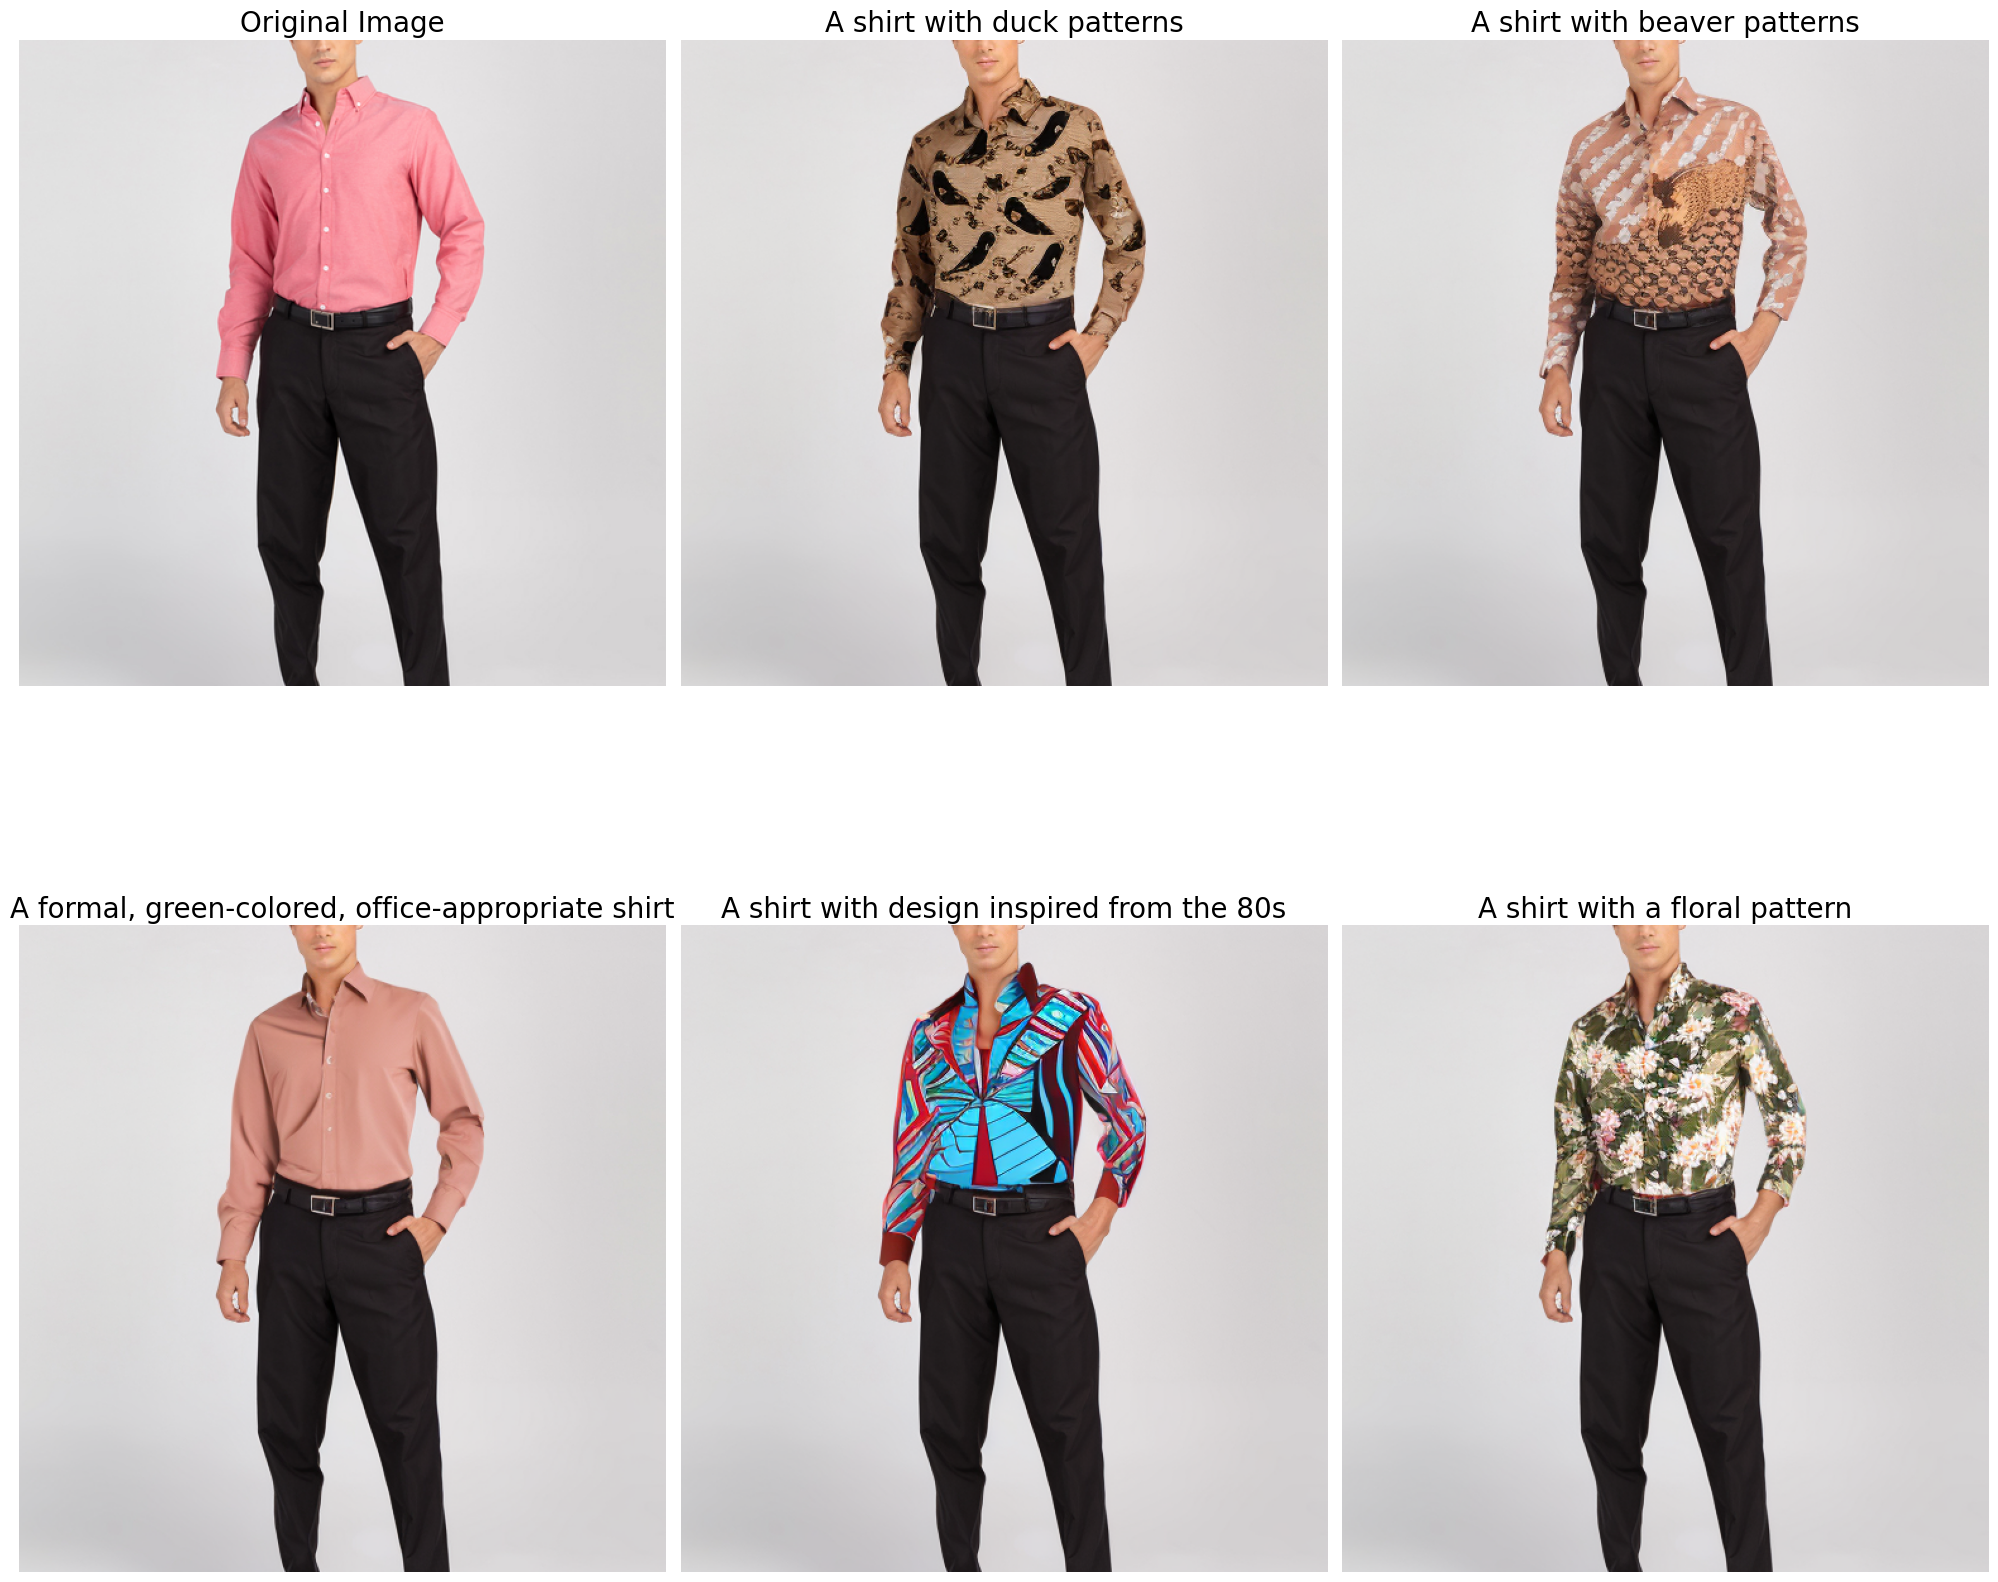

In [ ]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)